---
title: Linear Convection
suptitle: Linear Convection with JAX
short_title: Linear Convection
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

* Jax-ify
* Don't Reinvent the Wheel

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

$$
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} + c\frac{\partial u}{\partial y} = 0
$$ (eq:pde)

For the PDE {eq}`eq:pde`, we are going to do a forward difference discretization in space and a backwards in time. It is given by:

$$
u_{i,j}^{n+1} = u_{i,j}^{n} - c \frac{\Delta t}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right)
- c \frac{\Delta t}{\Delta y}\left( u_{i,j-1}-u_{i,j}^n \right)
$$ (eq:advection_discretize)

Citation [cite](dot:10.1175/JTECH-D-20-0104.1).

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import serket as sk
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb
import diffrax
import kernex as kx
import serket as sk

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# defime some variables
# nx, ny = 51, 51
# nt = 100
# c = 1.0
# dx, dy = 2/(nx-1), 2/(ny-1)

# sigma = 0.2
# dt = sigma * dx

nx, ny = 81, 81
nt = 100
c = 1.0
dx, dy = 2/(nx-1), 2/(ny-1)

dt = 0.001
t0 = 0
tmax = 0.5
ts = np.arange(t0, tmax, step=dt)

x_grid = np.linspace(0, 2, nx)
y_grid = np.linspace(0, 2, ny)

In [4]:
def init_hat(nx, ny, dx, dy):
    u = np.ones((nx,ny))
    
    u[int(.5 / dx):int(1 / dx + 1),
          int(.5 / dy):int(1 / dy + 1)] = 2
    
    return u

In [5]:
def fin_bump(x):
    if x <= 0 or x >= 1:
        return 0
    else:
        return 100*np.exp(-1./(x-np.power(x,2.)))

def init_smooth(nx, ny, dx, dy):
    
    u = np.ones((nx, ny))
    
    for ix in range(nx):
        for iy in range(ny):
            x = ix * dx
            y = iy * dy
            u[ix, iy] = fin_bump(x/1.5) * fin_bump(y/1.5) + 1.
                     
    return u

In [6]:
# initialize field to be zero
# u_init = init_hat(nx, ny, dx, dy)
u_init = init_smooth(nx, ny, dx, dy)

u = u_init.copy()

In [7]:
u.shape

(81, 81)

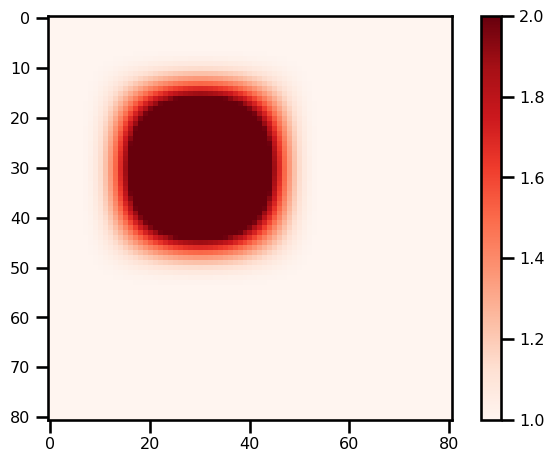

In [8]:
fig, ax = plt.subplots()
pts = ax.imshow(u, cmap="Reds", vmin=1.0, vmax=2.0)
plt.colorbar(pts)
plt.tight_layout()
plt.show()


Steps:

1. Calculate the RHS
2. Apply the Boundary Conditions


In [9]:
solns = dict()

In [10]:
ts.min(), ts.max()

(0.0, 0.499)

In [11]:
# initialize field to be zero
u_init = np.ones((nx,ny))
u_init[int(.5 / dx):int(1 / dx + 1),
      int(.5 / dy):int(1 / dy + 1)] = 2

u = u_init.copy()

for t in tqdm(ts):
    
    # copy to avoid overwriting
    un = u.copy()
    
    
    # calculate the terms
    t1 = un[1:, 1:]
    t2 = - c * (dt / dy) * (un[1:, 1:] - un[1:, :-1])
    t3 = - c * (dt / dx) * (un[1:, 1:] - un[:-1, 1:])
    
    u[1:, 1:] =  t1 + t2 + t3    
    
    
    # apply boundary conditions
    u[0, :] = 1. # left
    u[-1, :] = 1. # right
    u[:, 0] = 1. # bottom
    u[:, -1] = 1. # top


# small sanity check
# assert (u[45:55, 45:55] > 1.8).all()
solns["numpy"] = u

  0%|          | 0/500 [00:00<?, ?it/s]

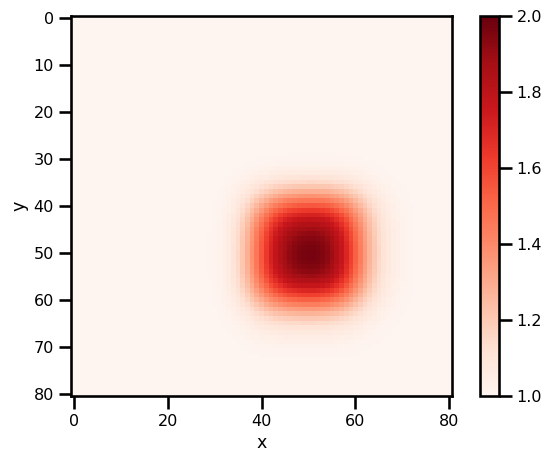

In [12]:
fig, ax = plt.subplots()
pts = ax.imshow(u, cmap="Reds", vmin=1.0, vmax=2.0)
ax.set(
    xlabel="x", ylabel="y"
)
plt.colorbar(pts)
plt.tight_layout()
plt.show()

## New API

### Domain

In [13]:
from jaxsw._src.domain import Domain, TimeDomain
from jaxsw._src.fields.base import Field
from jaxsw._src.operators.fd import Difference
from jaxsw._src.operators.custom import FuncOperator

In [14]:
xmin, ymin = 0., 0.
xmax, ymax = 2.0, 2.0
nx, ny = 81, 81
nt = 100
c = 1.0

# initialize spatial domain
domain = Domain.from_numpoints(xmin=(xmin,ymin), xmax=(xmax,ymax), N=(nx, ny))




In [15]:
domain.size, domain.dx

((81, 81), (0.025, 0.025))

### Initial Condition

In [16]:

# initialize field to be zero
def init_u_hat(domain):
    dx, dy = domain.dx
    
    u_init = jnp.ones(domain.size)
    u_init = u_init.at[
        int(.5 / dx):int(1 / dx + 1),
        int(.5 / dy):int(1 / dy + 1)
    ].set(2.0)
    
    return Field(u_init, domain)

def init_u_smooth(domain):
    dx, dy = domain.dx
    nx, ny = domain.size
    
    u_init = init_smooth(nx, ny, dx, dy)
    
    return Field(jnp.asarray(u_init), domain)

In [17]:
u = init_u_smooth(domain)
# u = init_u_hat(domain)
u

Field(
  values=f32[81,81],
  domain=Domain(xmin=(0.0, 0.0), xmax=(2.0, 2.0), dx=(0.025, 0.025))
)

### RHS

In [18]:

# initialize difference
f_du_dx = Difference(u.domain, axis=0, accuracy=1, method="backward")
f_du_dy = Difference(u.domain, axis=1, accuracy=1, method="backward")

In [19]:
from jaxtyping import PyTree, Float
# RHS function
def rhs_fn(u: Field, c: PyTree[float]) -> Float[Array, "D"]:
    """RHS for 1D Advection. 
    Uses a Backwards FD scheme
    """
    
    # FD
    du_dx = f_du_dx(u)
    du_dy = f_du_dy(u)
    
    u = du_dx + du_dy
    
    # constant
    u = eqx.tree_at(lambda x: x.values, u, - c * u.values)
    
    return u

In [20]:
u_ = rhs_fn(u, c)
u_

Field(
  values=f32[81,81],
  domain=Domain(xmin=(0.0, 0.0), xmax=(2.0, 2.0), dx=(0.025, 0.025))
)

### Boundary Conditions

In [21]:
def f(u: Float[Array, "Dx Dy"]) -> Float[Array, "Dx Dy"]:
    u = u.at[0,:].set(1.0)
    u = u.at[-1,:].set(1.0)
    u = u.at[:,0].set(1.0)
    u = u.at[:,-1].set(1.0)
    return u


In [22]:
from jaxsw._src.operators.custom import FuncOperator

In [23]:
bc_fn = FuncOperator(f)

u_ = bc_fn(u)

2023-03-14 17:59:12.714177: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


In [24]:
def vector_field(t, u, args):
    u = bc_fn(u)
    
    u = rhs_fn(u, c)
        
    return u

In [25]:
u = init_u_smooth(domain)
# u = init_u_hat(domain)

In [26]:
# # TOLERANCES
# rtol = 1e-5
# atol = 1e-5
# pcoeff = 0.3
# icoeff = 0.4
# dtmax = 0.001
# stepsize_controller = diffrax.PIDController(
#     pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=dtmax
# )
# type(stepsize_controller)

In [27]:
from typing import Optional
class DynamicalSystem(eqx.Module):
    solver: diffrax.AbstractSolver
    saveat: Optional[diffrax.SaveAt] = None
    controller: Optional[diffrax.PIDController]=None
    t_domain: TimeDomain
    
    def __init__(self, solver, t_domain, saveat=None, controller=None):
        self.solver = solver
        self.t_domain = t_domain
        self.saveat = saveat
        self.controller = controller
    
    def equation_of_motion(self, t: float, u: Field, args):
        u = bc_fn(u)
        u = rhs_fn(u, c)
        return u
    
    def integrate(self, u: Field, dt: float) -> Field:
        
        # solver = diffrax.ImplicitEuler()
        sol = diffrax.diffeqsolve(
            terms=diffrax.ODETerm(self.equation_of_motion),
            solver=self.solver,
            t0=self.t_domain.tmin,
            t1=self.t_domain.tmax,
            dt0=dt,
            y0=u,
            saveat=self.saveat,
            max_steps=None,
        )
        return sol.ys

In [28]:
# TEMPORAL DISCRETIZATION
t0 = 0.0
tmax = 0.5

# CFL condition
def cfl_cond(dx, c, sigma):
    assert sigma <= 1.0
    return (sigma * dx) / c

# temporal parameters
c = 0.9
sigma = 0.2
# dt = cfl_cond(dx=dx, c=c, sigma=sigma)
# dt = 0.0001
dt = 0.001



# TEMPORAL DISCRETIZATION
# initialize temporal domain
t_domain = TimeDomain(tmin=0.0, tmax=0.5, dt=dt)
ts = jnp.linspace(t0, tmax, 50)
saveat = diffrax.SaveAt(ts=ts)


# TIME STEPPER
solver = diffrax.Euler()

# DYNAMICAL SYSTEM
dyn_model = DynamicalSystem(solver, t_domain, saveat)

# integration
u_sol = dyn_model.integrate(u, dt)

In [29]:
u_sol.values.shape

(50, 81, 81)

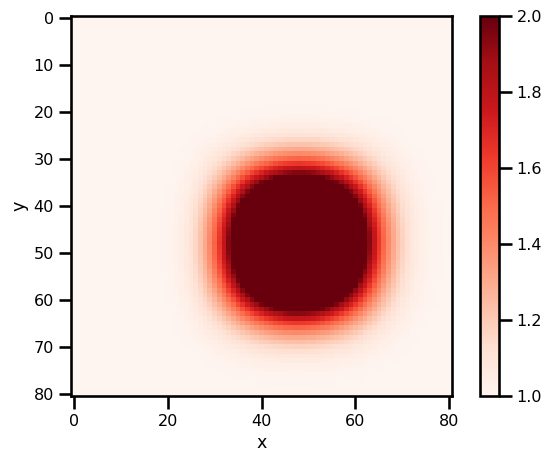

In [33]:
fig, ax = plt.subplots()
pts = ax.imshow(
    u_sol.values[-1], vmin=1.0, vmax=2.0,
    cmap="Reds")
ax.set(
    xlabel="x", ylabel="y"
)
plt.colorbar(pts)
plt.tight_layout()
plt.show()